In [1]:
#!pip install psycopg2


In [2]:
import psycopg2
import pandas as pd
import csv

### verify the conexion
try:
    # Connect to the database
    conn = psycopg2.connect(
        host="pg.ujueta.com",
        port="5432",
        user="consultoria",
        password="LmKTXJBXya!14]f9!2k]",
        database="postgres",
    )
except psycopg2.Error as e:
    print("Error connecting to the database:")
    print(e)
else:
    print("Connection established successfully")

Connection established successfully


In [3]:

### ventas diario apiladas
def export_forecast_to_csv():
    try:
        # connect to the database
        conn = psycopg2.connect(
            host="pg.ujueta.com",
            port="5432",
            user="consultoria",
            password="LmKTXJBXya!14]f9!2k]",
            database="postgres",
        )

        # create cursor
        with conn.cursor() as cur:

            # ececute a sql query

            cur.execute("SELECT * FROM forecast.ventas_diario")

            # fetch the results
            results = cur.fetchall()

            # open a file in the downloads folder

            with open(
                "/home/usuario/Escritorio/Consultorias_Empresariales/Ujueta/Datos/outputs.csv",
                "w",
                newline="",
            ) as f:
                # create a csv writer
                writer = csv.writer(f)

                # write the column names
                writer.writerow([col[0] for col in cur.description])

                # write the query results
                writer.writerows(results)
    except Exception as e:
        print(f"An error ocurred: {e}")
    finally:
        # close the cursor and connection
        if conn:
            conn.close()


# Call the function to export data to csv
export_forecast_to_csv()


In [4]:


### manipulate data

import pandas as pd

# carga de datas
data = pd.read_csv(
    "/home/usuario/Escritorio/Consultorias_Empresariales/Ujueta/Datos/outputs.csv"
)
# convertir en dataframe
df = pd.DataFrame(data)
df.head()

,docdate,codigo_articulo,cantidad
0,2022-01-03,AUACALR4,1
1,2022-01-03,AUACCH1,5
2,2022-01-03,AUACPB400,1
3,2022-01-03,AUACRIM4F,5
4,2022-01-03,AUACSH1000,3


In [5]:
df.shape

(87675, 3)

In [6]:
# List of SKUs to filter
selected_skus = [
    'AUACAE30', 'AUACPB400', 'AUACRIM4F', 'AUACSH1000', 'HEELAG1141',
    'HEELAG1142KIT', 'HEELPW1770', 'HEELXID20', 'HEFUFCD12KIT',
    'HEFUFCD21', 'HEFUFD52', 'HEFUFG71', 'SOELCSVM501', 'SOELCSVM530',
    'SOELSI6140DV', 'SOFUFW181', 'SOFUFW185', 'SOFUFW33', 'SOFUFW35',
    'SOSWP2-517'
]

# Filter the dataset
filtered_df = df[df['codigo_articulo'].isin(selected_skus)]

In [7]:
print(filtered_df)

          docdate codigo_articulo  cantidad
2      2022-01-03       AUACPB400         1
3      2022-01-03       AUACRIM4F         5
4      2022-01-03      AUACSH1000         3
10     2022-01-03      HEELAG1141        56
22     2022-01-03      HEELPW1770         4
...           ...             ...       ...
87608  2024-11-19    SOELSI6140DV         3
87624  2024-11-19       SOFUFW185         2
87627  2024-11-19        SOFUFW33        53
87628  2024-11-19        SOFUFW35         2
87663  2024-11-19      SOSWP2-517         9

[13131 rows x 3 columns]


In [8]:
data_highdda = filtered_df[filtered_df['docdate'] >= '2023-01-01']
data_highdda

,docdate,codigo_articulo,cantidad
26811,2023-01-02,HEELAG1141,5
26827,2023-01-02,HEFUFCD12KIT,212
26828,2023-01-02,HEFUFCD21,4
26830,2023-01-02,HEFUFD52,14
26831,2023-01-02,HEFUFG71,1
...,...,...,...
87608,2024-11-19,SOELSI6140DV,3
87624,2024-11-19,SOFUFW185,2
87627,2024-11-19,SOFUFW33,53
87628,2024-11-19,SOFUFW35,2


In [9]:
#========================================================================================================================================
# Ajuste de Datos para statsforecast
#========================================================================================================================================

#-- Dato de ejemplo para función

def data_sf(df, date = 'docdate', y = 'cantidad', unique_id = 'codigo_articulo'):
    df_m = df[[date, y, unique_id]]
    df_m.rename(columns={date : 'ds', y :'y', unique_id: 'unique_id'}, inplace=True)
  
    return df_m

df_m = data_sf(data_highdda, date = 'docdate', y = 'cantidad', unique_id = 'codigo_articulo')
df_m
df_m.info()




<class 'pandas.core.frame.DataFrame'>
Index: 8810 entries, 26811 to 87663
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ds         8810 non-null   object
 1   y          8810 non-null   int64 
 2   unique_id  8810 non-null   object
dtypes: int64(1), object(2)
memory usage: 275.3+ KB


In [10]:
#========================================================================================================================================
# Colección de modelos
#========================================================================================================================================
from statsforecast import StatsForecast #- Para instanciar los  modelos

from statsforecast.models import (
    AutoARIMA,
    AutoETS,
    HoltWinters,
    ADIDA,
    CrostonClassic as Croston, 
    IMAPA,
    TSB,
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive
)

#-- Parametros

# Número de días en el futuro a pronosticar
horizon = 30
# Ventana estacional: es 7 porque tenemos datos diarios
season_length = 7
# El número de dias que el modelo usará para hacer el forecast 
window_size = 6*30

# Lista de modelos a evaluar
models = [
    AutoARIMA(season_length=season_length),
    AutoETS(season_length=season_length),
    HoltWinters(season_length=season_length),
    ADIDA(),
    Croston(),
    IMAPA(),
    TSB(alpha_d = 0.2, alpha_p = 0.2),
    SeasonalNaive(season_length=season_length),
    HistoricAverage(),
    DOT(season_length=season_length)
]

In [11]:
# StatsForecast.plot(df_m)

# Instanciando StatsForecast como sf
sf = StatsForecast( 
    models=models,
    freq='D', 
    n_jobs=-1,
)


In [12]:
# Cross Validation
from functools import partial
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mape, mase, mse, smape

crossvaldation_df = sf.cross_validation(
    df=df_m,
    h=horizon,
    step_size=horizon,
    n_windows=3
)



/home/usuario/myenv/lib/python3.12/site-packages/statsforecast/core.py:494: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [13]:
def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['unique_id', 'ds', 'cutoff', 'y'], errors='ignore').columns.tolist()
    evals = []
    # Calculate loss for every unique_id and cutoff.    
    for cutoff in df['cutoff'].unique():
        eval_ = evaluate(df[df['cutoff'] == cutoff], metrics=[metric], models=models)
        evals.append(eval_)
    evals = pd.concat(evals)
    evals = evals.groupby('unique_id').mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals

evaluation_df = evaluate_cross_validation(crossvaldation_df.reset_index(drop=False), smape)
evaluation_df.head(22)

,AutoARIMA,AutoETS,HoltWinters,ADIDA,CrostonClassic,IMAPA,TSB,SeasonalNaive,HistoricAverage,DynamicOptimizedTheta,best_model
unique_id,,,,,,,,,,,
AUACAE30,0.490557,0.503904,0.503541,0.435080,0.435898,0.435080,0.390734,0.420123,0.460789,0.435080,TSB
AUACPB400,0.755707,0.399256,0.401808,0.400127,0.400255,0.400127,0.395664,0.442580,0.405451,0.400127,TSB
AUACRIM4F,0.574360,0.361250,0.367640,0.380135,0.380135,0.380135,0.391309,0.480293,0.361262,0.381606,AutoETS
AUACSH1000,0.568871,0.452751,0.438804,0.504485,0.478223,0.504485,0.492487,0.610980,0.458195,0.482276,HoltWinters
HEELAG1141,0.789032,0.632863,0.659134,0.622950,0.619960,0.622950,0.578770,0.617674,0.610471,0.622950,TSB
HEELAG1142KIT,0.634906,0.635286,0.639678,0.603341,0.608131,0.603341,0.609790,0.547852,0.561681,0.603341,SeasonalNaive
HEELPW1770,0.579074,0.604157,0.604843,0.640204,0.643322,0.640204,0.632481,0.535171,0.604007,0.640204,SeasonalNaive
HEELXID20,0.485297,0.395088,0.396592,0.438736,0.417333,0.438736,0.430936,0.443474,0.363673,0.418653,HistoricAverage
HEFUFCD12KIT,0.570137,0.471667,0.484719,0.518951,0.501714,0.518951,0.515732,0.576172,0.471655,0.502915,HistoricAverage


In [14]:
#--- Selección del mejor modelo
fcst_df = sf.forecast(df=df_m, 
                      h=horizon, 
                      ## level=[90]
                     )
fcst_df.head()

/home/usuario/myenv/lib/python3.12/site-packages/statsforecast/core.py:494: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,ds,AutoARIMA,AutoETS,HoltWinters,ADIDA,CrostonClassic,IMAPA,TSB,SeasonalNaive,HistoricAverage,DynamicOptimizedTheta
unique_id,,,,,,,,,,,
AUACAE30,2024-11-20,8.338581,9.417327,7.869323,7.425161,7.42619,7.425161,4.846889,2.0,7.188544,7.425161
AUACAE30,2024-11-21,8.338581,9.419086,8.516694,7.425161,7.42619,7.425161,4.846889,1.0,7.188544,7.425161
AUACAE30,2024-11-22,8.338581,9.420846,9.740522,7.425161,7.42619,7.425161,4.846889,5.0,7.188544,7.425161
AUACAE30,2024-11-23,8.338581,9.422606,8.043631,7.425161,7.42619,7.425161,4.846889,6.0,7.188544,7.425161
AUACAE30,2024-11-24,8.338581,9.424365,9.097285,7.425161,7.42619,7.425161,4.846889,1.0,7.188544,7.425161


/home/usuario/myenv/lib/python3.12/site-packages/statsforecast/core.py:1407: FutureWarning: Passing the ids as the index is deprecated. Please provide them as a column instead.
  warnings.warn(


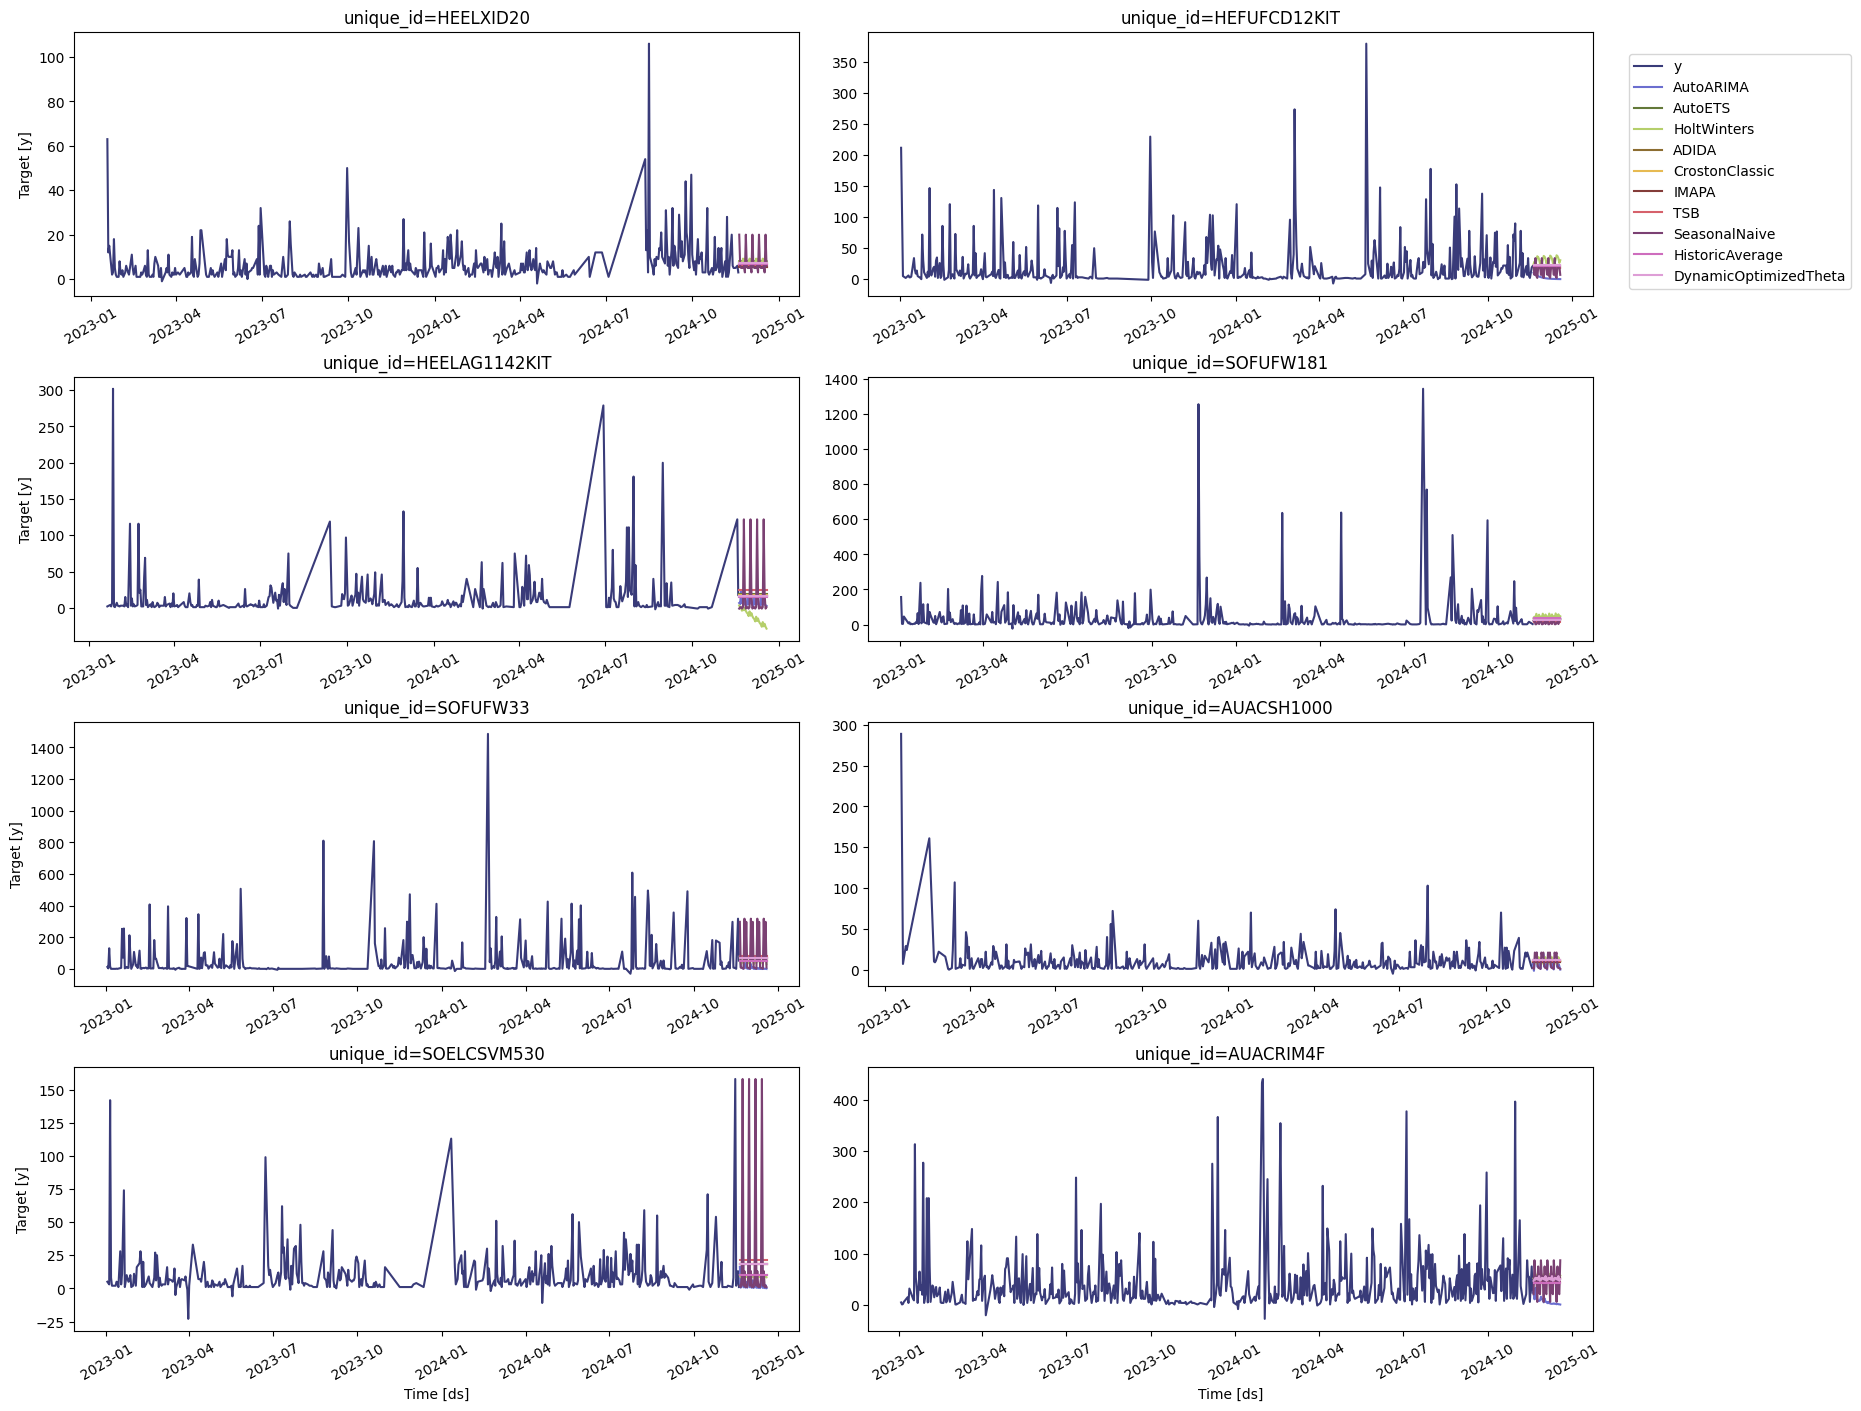

In [15]:
sf.plot(df_m,fcst_df)

In [17]:
def get_best_model_forecast(forecasts_df, evaluation_df):
    col_bm = evaluation_df['best_model'].values[0]
    df = forecasts_df[col_bm] # Wide to long 
    df = df.reset_index(drop=False)
    df.columns = ['unique_id', 'best_model']
    return df

prod_forecasts_df = get_best_model_forecast(forecasts_df = fcst_df, 
                                            evaluation_df = evaluation_df)
prod_forecasts_df

,unique_id,best_model
0,AUACAE30,4.846889
1,AUACAE30,4.846889
2,AUACAE30,4.846889
3,AUACAE30,4.846889
4,AUACAE30,4.846889
...,...,...
595,SOSWP2-517,16.921417
596,SOSWP2-517,16.921417
597,SOSWP2-517,16.921417
598,SOSWP2-517,16.921417
